# Thử nghiệm nhận diện mặt người nổi tiếng VN - Pipeline demo như 1 app thực tế

## Quy trình tổng quan:
* Lấy 1 tấm ảnh bất kì chưa đc preprocess
* Preprocess cần thiết
    * Detect các khuôn mặt
    * Align các mặt
* Đưa các mặt qua model đã train cho kết quả
* Visualize kết quả

In [1]:
from PIL import Image
import numpy as np
from mtcnn import MTCNN
import tensorflow as tf
import cv2
import face_alignment
from skimage import transform

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        # Normally, JUST ENABLE allow_growh
        #for gpu in gpus:
            #tf.config.experimental.set_memory_growth(gpu, True)
        # HOWEVER, MTCNN is troublesome with this
        # So we temporarily use FIXED 2GB of GPU MEM
        # CHANGE to suit your machine
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [5]:
DEFAULT_IMG_PATH = 'test.jpg'
CLASSIFIER_INPUT_SIZE = (160, 160)
CLASSIFIER_MODEL_PATH = './models/facenet_trained.h5'
DEFAULT_THRESHOLD = 60

In [6]:
CLASSIFIER = tf.keras.models.load_model(CLASSIFIER_MODEL_PATH)

In [7]:
ALIGNER = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cuda:0')

In [8]:
DETECTOR = MTCNN()

In [9]:
import json

LABELS_PATH = 'labels_map.json'
LABELS = json.load(open(LABELS_PATH, 'r', encoding='UTF-8'))
LABELS_NUM = list(LABELS.keys())
print(len(LABELS))

144


In [10]:
from PIL import ImageFont, ImageDraw
FONT = ImageFont.truetype('arial.ttf', size=32)

In [11]:
def get_labels(LABELS_PATH='original_labels.txt', encoding='UTF-8'):
    return [line.strip() for line in open(LABELS_PATH, 'r', encoding=encoding)]

def load_img(path):
    img = Image.open(path)
    img = img.convert('RGB')
    return img

def get_faces(img, detector=DETECTOR):
    pixels = np.asarray(img)

    boxes, faces = [], []
    results = detector.detect_faces(pixels)
    for res in results:
        x1, y1, w, h = res['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + w, y1 + h
        face = pixels[y1:y2, x1:x2]
        face = Image.fromarray(face)
        face = face.resize(CLASSIFIER_INPUT_SIZE)
        boxes.append([x1, y1, x2, y2, w, h])
        faces.append(face)

    return boxes, faces

from io import StringIO
from contextlib import redirect_stdout
fout = StringIO()

def align_face(face: Image, aligner=ALIGNER):
    CENTERED_FACE = np.array([
            [54.706573, 73.85186],
            [105.045425, 73.573425],
            [80.036, 102.48086],
            [59.356144, 131.95071],
            [101.04271, 131.72014]], dtype=np.float32)

    pixels = np.array(face)

    with redirect_stdout(fout):
        landmarks = aligner.get_landmarks(pixels)

    if landmarks:
        points = landmarks[0]
        p1 = np.mean(points[36:42, :], axis=0)
        p2 = np.mean(points[42:48, :], axis=0)
        p3 = points[33, :]
        p4 = points[48, :]
        p5 = points[54, :]
        dst = np.array([p1, p2, p3, p4, p5], dtype=np.float32)
        src = cv2.cvtColor(pixels, cv2.COLOR_RGB2BGR)

        trans = transform.SimilarityTransform()
        trans.estimate(dst, CENTERED_FACE)
        M = trans.params[0:2, :]
        aligned = cv2.warpAffine(src, M, CLASSIFIER_INPUT_SIZE, borderValue=0.0)

        return aligned
    return pixels

def predict(face: np.ndarray, classifier:tf.keras.Model=CLASSIFIER):
    inp = face.reshape((-1,) + face.shape) 
    # -1 will create a batch with varied length like (None, 160, 160, 3)
    # or use tf.expand_dims(face, 0)
    predictions = classifier.predict(inp)
    prediction = LABELS[LABELS_NUM[np.argmax(predictions)]]
    confidence = 100 * np.max(predictions)
    return prediction, confidence

from os import listdir, path

def visualize(boxes: list, predictions: list, img_path, threshold=DEFAULT_THRESHOLD):
    img = cv2.imread(img_path)

    for box, prediction in zip(boxes, predictions):
        label, conf = prediction[0], prediction[1]

        if conf >= threshold:
            img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(0, 0, 255), thickness=3)

            # cv2 not support unicode text
            img_pil = Image.fromarray(img)
            draw = ImageDraw.Draw(img_pil)
            draw.text((box[0], box[1] - 35), label, fill=(0, 165, 255), font=FONT, stroke_width=2, stroke_fill=(0, 0, 0))
            img = np.array(img_pil)

            print('*', label, '-', '{:.2f}%'.format(conf))
        else:
            img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)

            print(label, '-', '{:.2f}%'.format(conf))


    res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    org_fname = os.path.splitext(img_path)
    fname = org_fname[0] + '-recognized' + '.jpg'
    cv2.imwrite(fname, img)

    a = Image.open(fname)
    a.show()
    plt.imshow(res)
    plt.axis('off')

    return res

import time

def process(img_path=DEFAULT_IMG_PATH, threshold=DEFAULT_THRESHOLD):
    tick = time.perf_counter()

    img = load_img(img_path)

    boxes, faces = get_faces(img)
    predictions = []
    for box, face in zip(boxes, faces):
        aligned_face = align_face(face)
        prediction, confidence = predict(aligned_face)
        predictions.append((prediction, confidence))
    
    print('Processed in %f second(s)' % (time.perf_counter() - tick))
    return visualize(boxes, predictions, img_path, threshold)

In [17]:
TEST_DIR = 'demo_test_imgs'
tests = listdir(TEST_DIR)

Processed in 1.078974 second(s)
* Chí Tài - 99.97%
* Hoài Linh - 69.56%


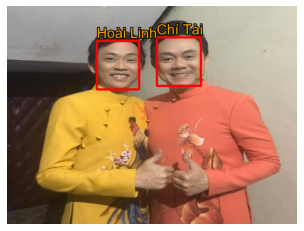

In [18]:
res1 = process(path.join(TEST_DIR, tests[0]))

Processed in 1.375677 second(s)
* Hoài Lâm - 99.96%
* Trường Giang - 99.87%
* Đàm Vĩnh Hưng - 99.73%


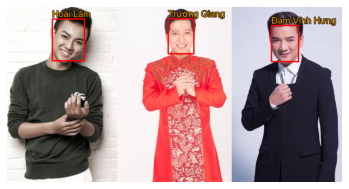

In [19]:
res2 = process(path.join(TEST_DIR, tests[1]))

Processed in 1.854766 second(s)
* Trấn Thành - 99.63%
* Lê Lộc - 91.34%
Phương Vy - 60.70%
Ninh Dương Lan Ngọc - 54.21%
* Mỹ Linh - 92.45%


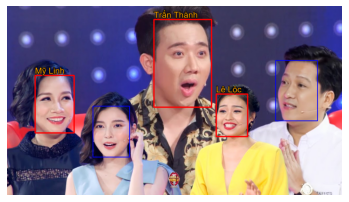

In [20]:
res3 = process(path.join(TEST_DIR, tests[2]), threshold=70)

Processed in 7.302834 second(s)
Hoàng Mèo - 69.46%
Nguyễn Thị Ánh Viên - 18.83%
Nguyễn Thị Ánh Viên - 51.14%
ST Sơn Thạch - 20.17%
Tiến Luật - 70.23%
Orange (ca sĩ) - 19.83%
Nguyễn Thị Ánh Viên - 45.12%
Phương Vy - 40.67%
Misthy - 63.64%
* Thanh Duy (ca sĩ) - 85.05%
Ngân Khánh - 22.49%
Lou Hoàng - 33.96%
Nguyễn Thị Ánh Viên - 65.02%
* Lại Văn Sâm - 99.79%
Miko Lan Trinh - 55.17%
Như Quỳnh - 48.07%
Thanh Duy (ca sĩ) - 11.40%
Tự Long - 33.32%
Min (ca sĩ) - 21.91%
Trúc Nhân - 30.92%
* Thanh Bạch - 97.67%
Miko Lan Trinh - 13.51%
Thuỷ Tiên (ca sĩ) - 29.98%


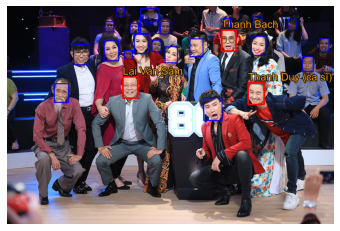

In [21]:
res4 = process(path.join(TEST_DIR, tests[3]), threshold=80)